# Tutorial

In this tutorial I'll demonstrate some functionality of the `sensormotion` package by walking through some workflow examples using simulated data. The examples will cover:

 1. Extracting gait dynamics (e.g. cadence, step time, stride regularity) from vertical acceleration
 2. Calculating physical activity counts from triaxial acceleration

# 0. Imports

First, lets import the packages we'll be using

# 1. Gait dynamics

## 1a. Simulating data

For demonstration purposes, lets simulate 10 seconds of noisy walking data from a triaxial accelerometer. In reality this would be raw acceleration data from the sensor.

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import sensormotion as sm

sampling_rate = 100  # number of samples per second
seconds = 10
time = np.arange(0, seconds*sampling_rate) * 10  # times in milliseconds

np.random.seed(123)

x = 2*np.sin(time/30) + np.random.normal(0.5, 0.4, len(time))  # ML medio-lateral
y = 4*np.sin(time/80) + np.random.normal(1.0, 0.5, len(time))  # VT vertical
z = 3*np.sin(time/90) + np.random.normal(0.0, 0.4, len(time))  # AP antero-posterior

# print(x)
print(time.shape)
print(time.shape)

(1000,)
(1000,)


Plot the signals

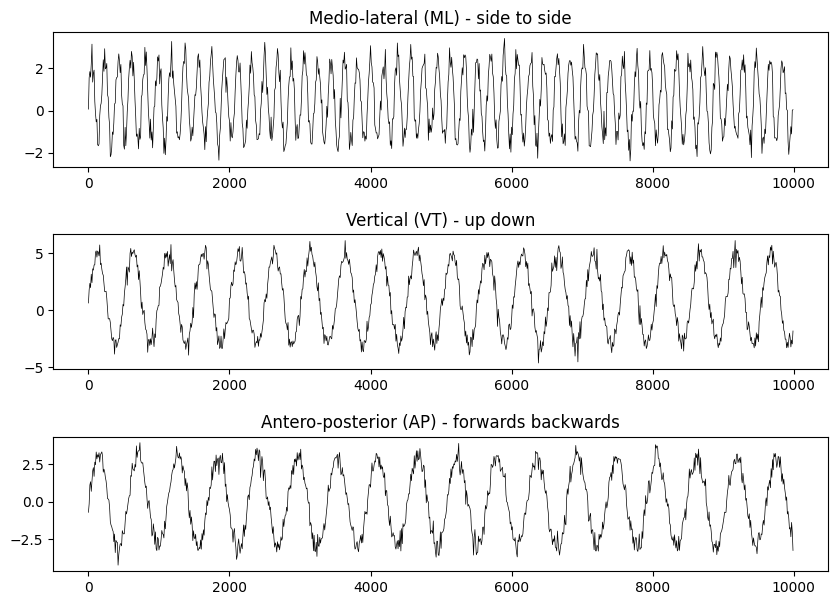

In [4]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,7))

ax[0].set_title('Medio-lateral (ML) - side to side')
ax[0].plot(time, x, linewidth=0.5, color='k')

ax[1].set_title('Vertical (VT) - up down')
ax[1].plot(time, y, linewidth=0.5, color='k')

ax[2].set_title('Antero-posterior (AP) - forwards backwards')
ax[2].plot(time, z, linewidth=0.5, color='k')

fig.subplots_adjust(hspace=.5)

The package contains a wrapper around `matplotlib` to make plotting a bit simpler. The plot above can also be created using `sm.plot.plot_signal()`

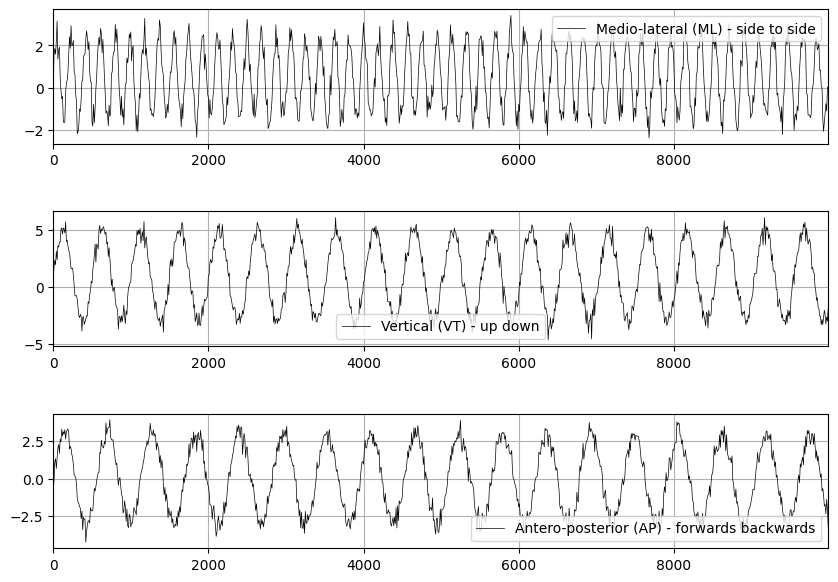

In [9]:
sm.plot.plot_signal(time, [{'data': x, 'label': 'Medio-lateral (ML) - side to side', 'line_width': 0.5},
                           {'data': y, 'label': 'Vertical (VT) - up down', 'line_width': 0.5},
                           {'data': z, 'label': 'Antero-posterior (AP) - forwards backwards', 'line_width': 0.5}],
                    subplots=True, fig_size=(10,7))

## 1b. Filtering

First, we might want to identify the dominant frequencies in our signal to know the ideal thresholds for our filter. As this is only simulated data, there is little variability in the power spectrum. In reality, movement data (such as walking) can usually be low-pass filtered at 10Hz, but this depends on the specific application and the axis of interest.

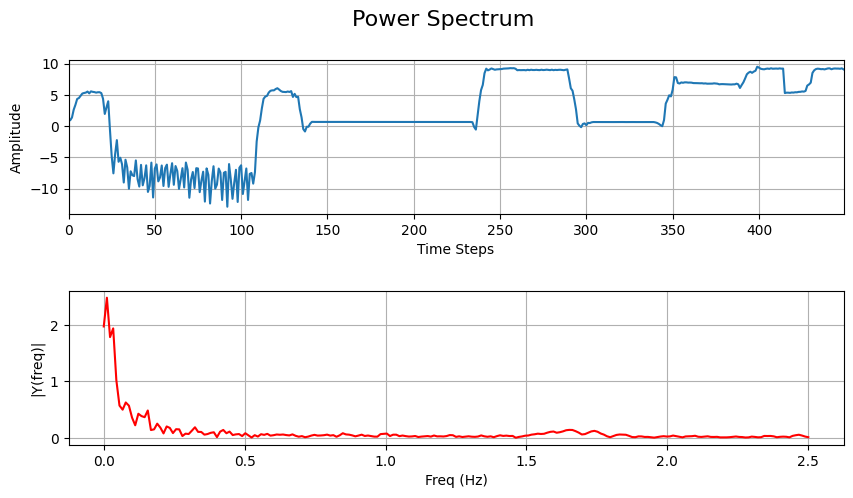

In [17]:
_ = sm.signal.fft(y, sampling_rate, plot=True)

Next, we can use some of the other plotting tools in the package to fine-tune a filter by visualizing the filter response curve. Here we can see the response of a 4th order 10Hz low pass Butterworth filter

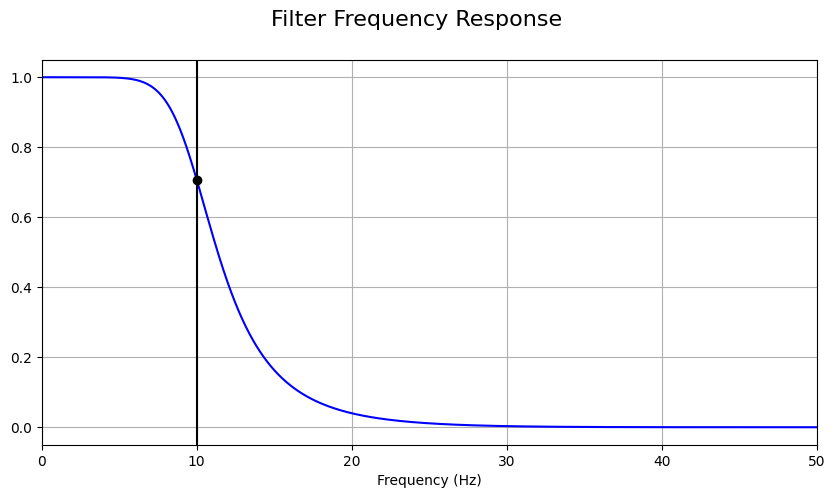

In [10]:
sm.plot.plot_filter_response(10, sampling_rate, 'low', filter_order=4)

Then we can build the actual filter, and use it to filter each of our acceleration signals

In [20]:
# Build the filter
b, a = sm.signal.build_filter(10, sampling_rate, 'low', filter_order=4)

# Filter signals
x_f = sm.signal.filter_signal(b, a, x)  # ML medio-lateral
y_f = sm.signal.filter_signal(b, a, y)  # VT vertical
z_f = sm.signal.filter_signal(b, a, z)  # AP antero-posterior

ValueError: Digital filter critical frequencies must be 0 < Wn < 1

NameError: name 'time' is not defined

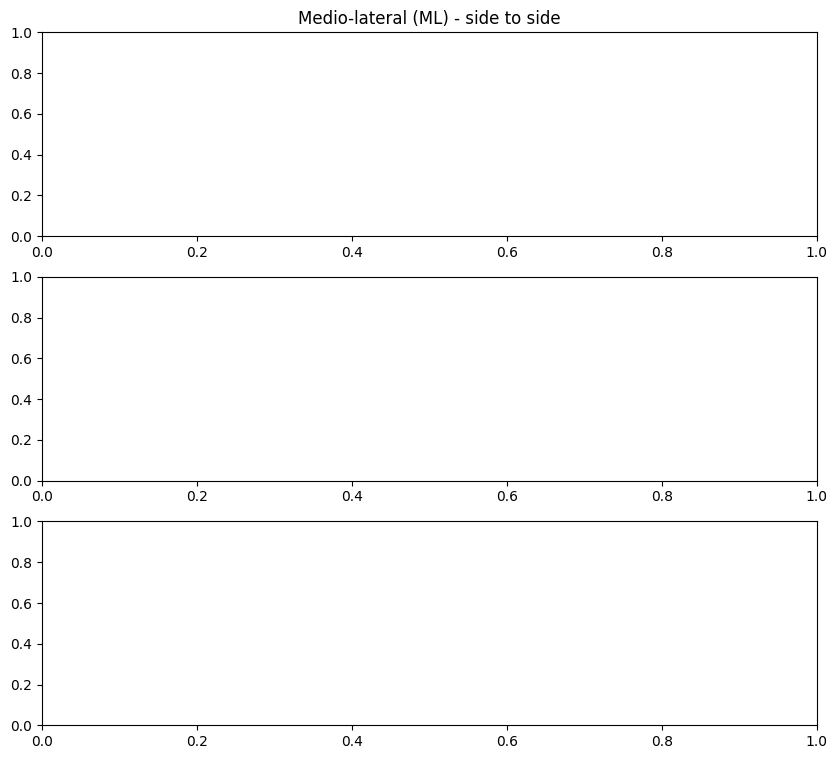

In [21]:
# Create plots with overlaid filtered signals (in red)
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,9))

ax[0].set_title('Medio-lateral (ML) - side to side')
ax[0].plot(time, x, linewidth=0.3, color='k')
ax[0].plot(time, x_f, linewidth=0.8, color='r')

ax[1].set_title('Vertical (VT) - up down')
ax[1].plot(time, y, linewidth=0.3, color='k')
ax[1].plot(time, y_f, linewidth=0.9, color='r')

ax[2].set_title('Antero-posterior (AP) - forwards backwards')
ax[2].plot(time, z, linewidth=0.3, color='k')
ax[2].plot(time, z_f, linewidth=0.9, color='r')

fig.subplots_adjust(hspace=.5)

## 1c. Extracting gait metrics

We can extract gait metrics, such as cadence and step time, from the filtered acceleration signals. Typically this is done using the vertical axis (`Y` in this case), although there are also use cases for looking at the ML axis. The first step is to identify the "valleys" in the vertical signal

In [22]:
peak_times, peak_values = sm.peak.find_peaks(time, y_f, peak_type='valley', min_val=0.6, min_dist=10, plot=True)

NameError: name 'time' is not defined

With the valleys identified, we can calculate various gait metrics

In [10]:
step_count = sm.gait.step_count(peak_times)
cadence = sm.gait.cadence(time, peak_times)
step_time, step_time_sd, step_time_cov = sm.gait.step_time(peak_times)

print(' - Number of steps: {}'.format(step_count))
print(' - Cadence: {:.2f} steps/min'.format(cadence))
print(' - Mean step time: {:.2f}ms'.format(step_time))
print(' - Step time variability (standard deviation): {:.2f}'.format(step_time_sd))
print(' - Step time variability (coefficient of variation): {:.2f}'.format(step_time_cov))

 - Number of steps: 20
 - Cadence: 120.12 steps/min
 - Mean step time: 501.58ms
 - Step time variability (standard deviation): 15.98
 - Step time variability (coefficient of variation): 0.03


We can also calculate autocorrelation-based metrics like step regularity, stride regularity, and step symmetry. To do this, we need to calculate the autocorrelation (AC) of the vertical (`Y`) signal, detect peaks in the AC, and then calculate the gait metrics. The example here shows highly regular steps due to the simulated nature of the data.

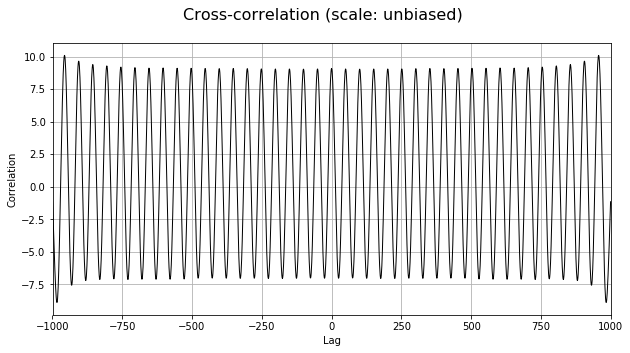

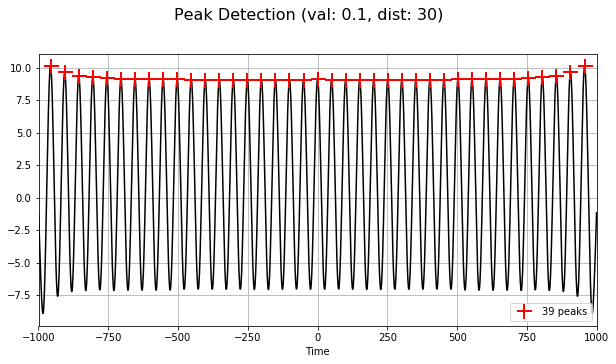

 - Step regularity: 0.9959
 - Stride regularity: 0.9943
 - Step symmetry: 0.9983


In [11]:
ac, ac_lags = sm.signal.xcorr(y_f, y_f, scale='unbiased', plot=True)

ac_peak_times, ac_peak_values = sm.peak.find_peaks(ac_lags, ac, peak_type='peak', min_val=0.1, min_dist=30, plot=True)

step_reg, stride_reg = sm.gait.step_regularity(ac_peak_values)
step_sym = sm.gait.step_symmetry(ac_peak_values)

print(' - Step regularity: {:.4f}'.format(step_reg))
print(' - Stride regularity: {:.4f}'.format(stride_reg))
print(' - Step symmetry: {:.4f}'.format(step_sym))

# 2. Physical activity

This package can also be used to categorize epochs (windows) of physical activity into different intensity levels based on pre-defined cut-points from the MVPA literature.

## 2a. Simulating data

For demonstration purposes, lets simulate 10 minutes of noisy walking data from a triaxial accelerometer. In reality this would be raw acceleration data from the sensor.

In [12]:
sampling_rate = 100  # number of samples per second
seconds = 600
time = np.arange(0, seconds*sampling_rate+1) * 10  # times in milliseconds

np.random.seed(123)

x = 2*np.sin(time/30) + np.random.normal(0.5, 0.4, len(time))  # ML medio-lateral
y = 4*np.sin(time/80) + np.random.normal(1.0, 0.5, len(time))  # VT vertical
z = 3*np.sin(time/90) + np.random.normal(0.0, 0.4, len(time))  # AP antero-posterior

# Adjust amount of movement at various timepoints
signals = [x, y, z]

for s in signals:
    s[20000:40000] = s[20000:40000] * 10
    s[40000:] = s[40000:] * 50

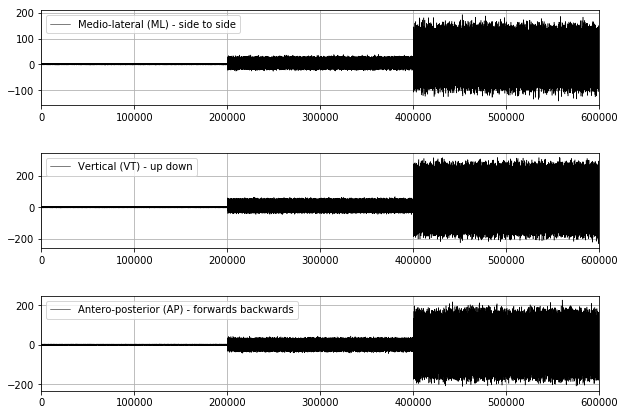

In [13]:
sm.plot.plot_signal(time, [{'data': x, 'label': 'Medio-lateral (ML) - side to side', 'line_width': 0.5},
                           {'data': y, 'label': 'Vertical (VT) - up down', 'line_width': 0.5},
                           {'data': z, 'label': 'Antero-posterior (AP) - forwards backwards', 'line_width': 0.5}],
                    subplots=True, fig_size=(10,7))

## 2b. Calculating PA counts

Physical activity counts are the area under the acceleration curve within a fixed-sized window (aka an epoch). Typically, we use 60-second epochs, so the signal is sliced into 60-second sections, then for each slice we calculate the PA count by integrating the signal. So, for a 10-minute period of walking, we will end up with 10 count values (1 for each minute), each representing the amount of movement over a minute.

We first need to convert each axis into their own count vectors. The following function does this by first rectifying the signal (zeroing or flipping the negative values), and uses numerical integration to calculate the PA count for each 60-second time slice.

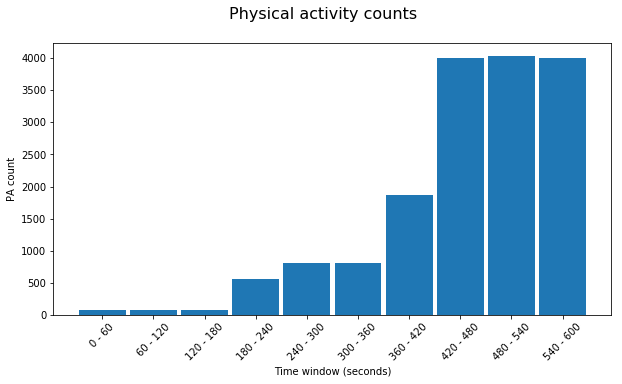

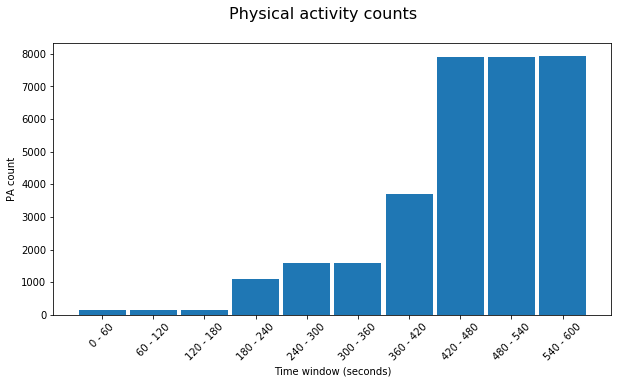

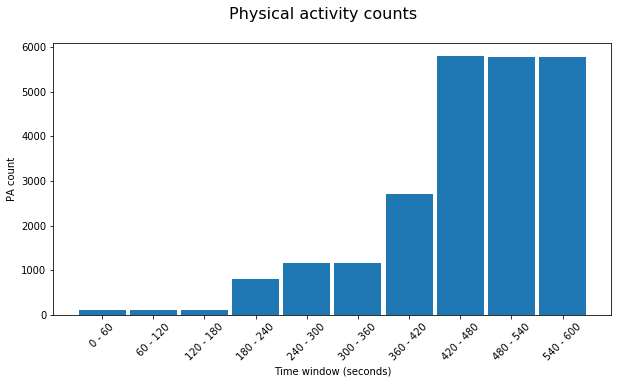

In [14]:
x_counts = sm.pa.convert_counts(x, time, time_scale='ms', epoch=60, rectify='full', integrate='simpson', plot=True)
y_counts = sm.pa.convert_counts(y, time, time_scale='ms', epoch=60, rectify='full', integrate='simpson', plot=True)
z_counts = sm.pa.convert_counts(z, time, time_scale='ms', epoch=60, rectify='full', integrate='simpson', plot=True)

At this point, if we only had a uniaxial accelerometer we can jump straight to using cut-points to categorize each epoch into intensity levels. However, with a triaxial accelerometer an extra step is required. We need to take the 3 count vectors we just generated and calculate the vector magnitude (VM) of counts, which will then be categorized

In [15]:
vm = sm.signal.vector_magnitude(x_counts, y_counts, z_counts)

## 2c. Categorizing PA intensity

With our vector magnitude, we can then use pre-defined cut-point sets to categorize each epoch into PA intensities (e.g. sedentary, moderate, vigorous). Cut-point sets are count thresholds from published research articles, and multiple sets are included in this package (for use with different populations).

Cut-point set: butte_preschoolers (axis count: 3)...
sedentary: -inf to 819
light: 820 to 3907
moderate: 3908 to 6111
vigorous: 6112 to inf


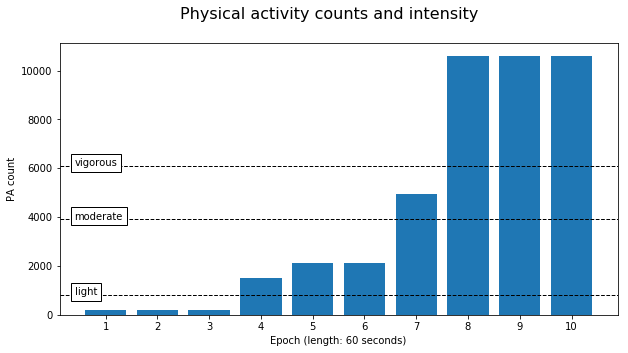

In [16]:
categories, time_spent = sm.pa.cut_points(vm, set_name='butte_preschoolers', n_axis=3, plot=True)

The function returns the category labels for each epoch, along with the amount of time spent at each intensity level (which is just the number of epochs at each intensity)

In [17]:
print('Categories: {}\n'.format(categories))
print('Time spent:')
print(time_spent)

Categories: ['sedentary', 'sedentary', 'sedentary', 'light', 'light', 'light', 'moderate', 'vigorous', 'vigorous', 'vigorous']

Time spent:
[['light' 'moderate' 'sedentary' 'vigorous']
 ['3' '1' '3' '3']]
